<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/6.convolutional_neural_networks/6_6_convolutional_neural_networks_(LeNet)_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [15]:
def net():

  return tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
      tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
      tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
      tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(120, activation='sigmoid'),
      tf.keras.layers.Dense(84, activation='sigmoid'),
      tf.keras.layers.Dense(10)])

In [16]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2D output shape: 	 (1, 28, 28, 6)
AveragePooling2D output shape: 	 (1, 14, 14, 6)
Conv2D output shape: 	 (1, 10, 10, 16)
AveragePooling2D output shape: 	 (1, 5, 5, 16)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


In [17]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [18]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [19]:
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
  device_name = device._device_name
  strategy = tf.distribute.OneDeviceStrategy(device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = net_fn()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[PlotLossesKeras()])
  return net

In [20]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

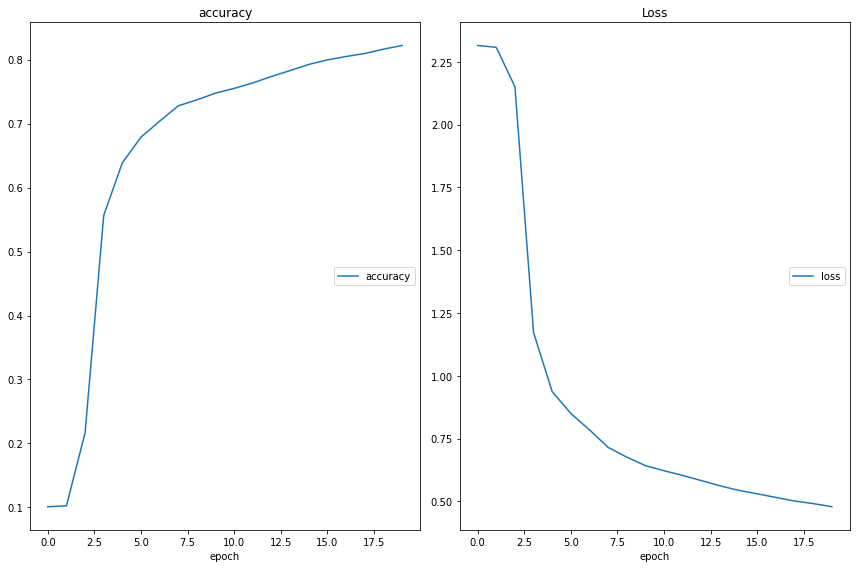

accuracy
	accuracy         	 (min:    0.101, max:    0.822, cur:    0.822)
Loss
	loss             	 (min:    0.479, max:    2.315, cur:    0.479)


In [23]:
lr, num_epochs = 0.3, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())